 # Лабораторная работа №6: Градиентный бустинг





 Вечканова П.А., группа 6133-010402


## Задание:

1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать категориальные и количественные признаки.
2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.
3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).
   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".
   - Итого получить 6 обученных моделей.
   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).
   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.
4. Важность признаков:
   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.
   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.
   - Построить график `shap.plots.bar` для одного объекта выборки.
   - Построить график `shap.plots.waterfall` для одного объекта выборки.
   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.
   - Построить график `shap.plots.beeswarm` для всех признаков.
   - Построить график `shap.plots.bar` для всех признаков.
   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.
   - Сравнить метрики до и после фильтрации.
   - Визуализировать полученное дерево решений.
5. Регрессия:
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.
   - Сравнить метрики до и после фильтрации.

In [106]:
!pip install catboost shap

In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
import shap
import matplotlib.pyplot as plt

## 1. Считать в `pandas.dfFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [108]:
df = pd.read_csv("/content/Star3642_balanced.csv")

df.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,5.99,13.73,0.58,1.318,K5III,16.678352,0
1,8.70,2.31,1.29,-0.045,B1II,15.518060,0
2,5.77,5.50,1.03,0.855,G5III,14.471813,0
3,6.72,5.26,0.74,-0.015,B7V,15.324928,1
4,8.76,13.44,1.16,0.584,G0V,19.401997,1


## 2. Датасет и подготовка данных:

   - Привести описание датасета.


Датасет содержит признаки:

| Признак     | Описание                                                                 |
|-------------|--------------------------------------------------------------------------|
| Vmag        | Видимая звёздная величина (чем меньше значение, тем ярче звезда)          |
| Plx         | Параллакс звезды (используется для расчёта расстояния до звезды в парсеках) |
| e_Plx       | Стандартная ошибка параллакса (рекомендуется удалить строки с высокой погрешностью) |
| B-V         | Цветовой индекс B-V (0 или отрицательный — горячие звёзды, 2.0 — холодные) |
| SpType      | Спектральный класс звезды (например, K3III, B1II, G3III и т.д.)           |
| Amag        | Абсолютная звёздная величина (яркость звезды на стандартном расстоянии 10 пк) |
| TargetClass | Класс звезды: 0 — карлик, 1 — гигант                                      |

   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".


In [109]:
df = df[df['e_Plx'] / df['Plx'] < 0.2]
df = df.dropna()
df = df.drop(columns=['e_Plx'])

   - Нормализовать численные данные.


In [110]:
numeric_features = ['Vmag', 'Plx', 'B-V', 'Amag']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

- Разбить выборку на обучающую и тестовую.


In [111]:
X = df.drop(columns=['TargetClass'])
y = df['TargetClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [112]:
cat_features = ['SpType']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_enc = pd.DataFrame(encoder.fit_transform(X_train[cat_features]),
                           columns=encoder.get_feature_names_out(cat_features),
                           index=X_train.index)
X_test_enc = pd.DataFrame(encoder.transform(X_test[cat_features]),
                          columns=encoder.get_feature_names_out(cat_features),
                          index=X_test.index)
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]
X_train_encoded = pd.concat([X_train_num, X_train_enc], axis=1)
X_test_encoded = pd.concat([X_test_num, X_test_enc], axis=1)

X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [117]:
X_train_raw['SpType'] = X_train_raw['SpType'].astype('category')
X_test_raw['SpType'] = X_test_raw['SpType'].astype('category')

## 3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):


   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).


In [118]:
target_classes = sorted(y.unique())
models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

In [119]:
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 10]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3]
    }
}

In [120]:
grid_results = {}
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train_encoded, y_train)
    grid_results[name] = grid
    best_models[name] = grid.best_estimator_
    print(name, grid.best_params_)

Tuning AdaBoost...
AdaBoost {'learning_rate': 1, 'n_estimators': 100}
Tuning GradientBoosting...
GradientBoosting {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 10}
Tuning CatBoost...
CatBoost {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".


In [121]:

xgb_raw = xgb.XGBClassifier(
    **grid_results['XGBoost'].best_params_,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(target_classes),
    enable_categorical=True,
    random_state=42
)
cat_raw = CatBoostClassifier(
    **grid_results['CatBoost'].best_params_, verbose=0, random_state=42
)
xgb_raw.fit(X_train_raw, y_train)
cat_raw.fit(X_train_raw, y_train, cat_features=['SpType'])
best_models['XGBoost_raw'] = xgb_raw
best_models['CatBoost_raw'] = cat_raw

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:29:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   - Итого получить 6 обученных моделей.

   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).


In [122]:
from sklearn.preprocessing import LabelEncoder
y_test_enc = LabelEncoder().fit_transform(y_test)

for name, model in best_models.items():
    X_eval = X_test_encoded if 'raw' not in name else X_test_raw
    y_pred = model.predict(X_eval)
    if hasattr(y_pred, 'toarray'):
        y_pred = y_pred.toarray()
    if hasattr(y_test, 'toarray'):
        y_test_use = y_test.toarray()
    else:
        y_test_use = y_test_enc
    print(f"Results for {name}:")
    print(classification_report(y_test_use, y_pred, target_names=[str(c) for c in target_classes]))


Results for AdaBoost:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       128
           1       0.88      0.94      0.91       229

    accuracy                           0.88       357
   macro avg       0.88      0.86      0.87       357
weighted avg       0.88      0.88      0.88       357

Results for GradientBoosting:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       128
           1       0.94      0.96      0.95       229

    accuracy                           0.94       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.94      0.94      0.94       357

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       128
           1       0.92      0.92      0.92       229

    accuracy                           0.89       357
   macro avg       0.88      0.88      0.88       357
w

   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.


In [123]:
best_name = max(best_models, key=lambda n: classification_report(
    y_test_enc,
    LabelEncoder().fit_transform(best_models[n].predict(X_test_encoded if 'raw' not in n else X_test_raw)),
    output_dict=True
)['macro avg']['f1-score'])

best = best_models[best_name]

In [124]:
best

Лучшая модель (как и ожидалось) CatBoost с параметрами



              precision     recall  f1-score   support

           0       0.92      0.96      0.94       128
           1       0.98      0.95      0.96       229

    accuracy                           0.96       357
    macro avg       0.95      0.96     0.95       357
    weighted avg    0.96      0.96     0.96       357

## 4. Важность признаков:


   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.


In [125]:
if 'CatBoost' in best_name:
    explainer = shap.Explainer(best)
    shap_values = explainer(X_train_raw)
else:
    explainer = shap.Explainer(best)
    shap_values = explainer(X_train_encoded)


   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.


In [126]:
shap.initjs()
shap.plots.force(shap_values[0])

In [127]:
shap.initjs()
shap.plots.force(shap_values[:10])

   - Построить график `shap.plots.bar` для одного объекта выборки.


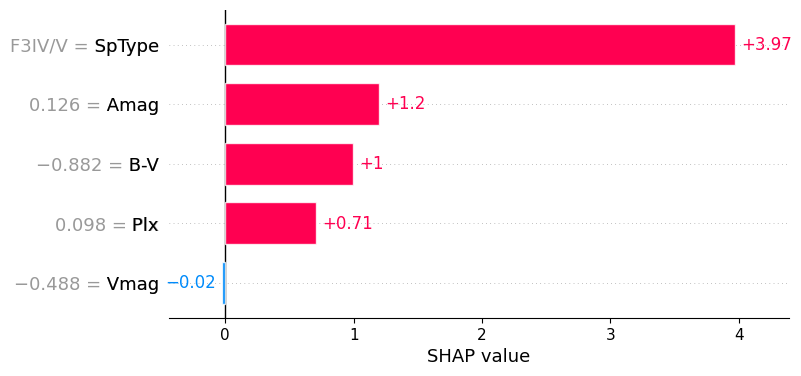

In [128]:
shap.plots.bar(shap_values[0])

   - Построить график `shap.plots.waterfall` для одного объекта выборки.


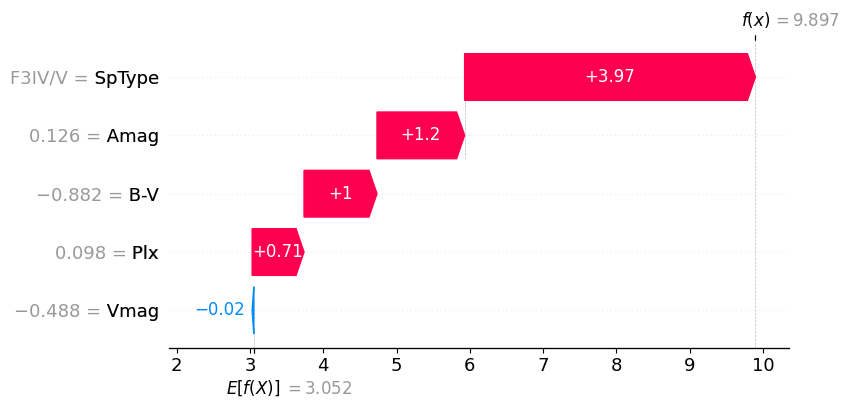

In [129]:
shap.plots.waterfall(shap_values[0])

   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.


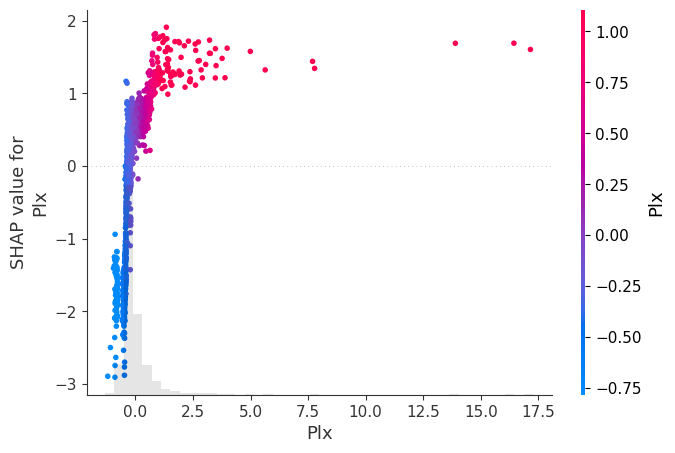

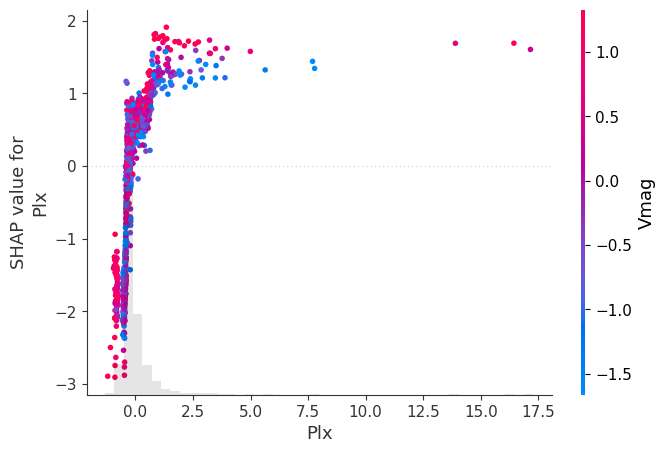

In [130]:
shap.plots.scatter(shap_values[:, "Plx"], color=shap_values[:, "Plx"])
shap.plots.scatter(shap_values[:, "Plx"], color=shap_values[:, "Vmag"])

   - Построить график `shap.plots.beeswarm` для всех признаков.


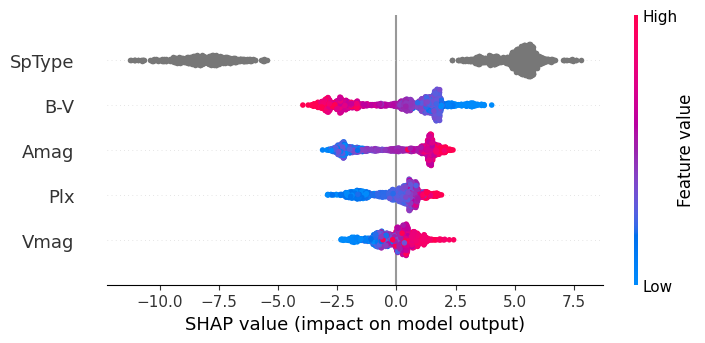

In [131]:
shap.plots.beeswarm(shap_values)

   - Построить график `shap.plots.bar` для всех признаков.


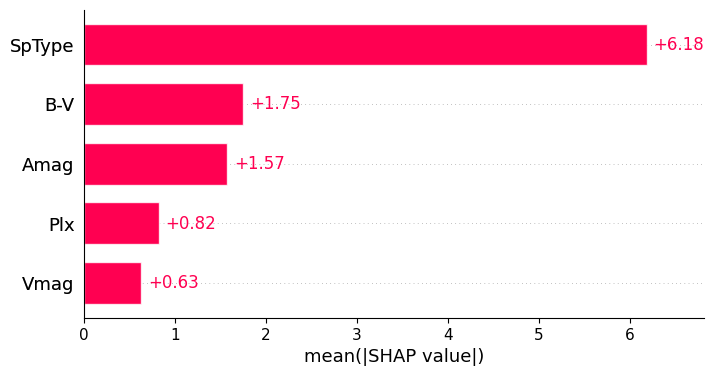

In [132]:
shap.plots.bar(shap_values)

   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.


In [139]:
if 'CatBoost' in best_name:
    importance_df = pd.DataFrame({'feature': X_train_raw.columns, 'importance': np.abs(shap_values.values).mean(0)})
    top_features = importance_df.sort_values('importance', ascending=False)['feature'].head(10).tolist()

    if 'SpType' not in top_features:
        top_features = ['SpType'] + top_features[:9]
    X_train_raw['SpType'] = X_train_raw['SpType'].astype(str)
    X_test_raw['SpType'] = X_test_raw['SpType'].astype(str)

    X_train_filt = X_train_raw[top_features]
    X_test_filt = X_test_raw[top_features]
    filtered = cat_raw
    filtered.fit(
        X_train_filt,
        y_train,
        cat_features=['SpType']
    )
else:
    importance_df = pd.DataFrame({'feature': X_train_encoded.columns, 'importance': np.abs(shap_values.values).mean(0)})
    top_features = importance_df.sort_values('importance', ascending=False)['feature'].head(10).tolist()
    X_train_filt = X_train_encoded[top_features]
    X_test_filt = X_test_encoded[top_features]
    filtered = xgb_raw

   - Сравнить метрики до и после фильтрации.


In [140]:
y_pred_filt = filtered.predict(X_test_filt)
y_pred_filt_enc = label_encoder.transform(pd.Series(y_pred_filt))
print("Filtered model results:")
try:
    y_test_str = label_encoder.inverse_transform(y_test_enc)
    y_pred_str = label_encoder.inverse_transform(y_pred_filt_enc)
    target_names = [str(c) for c in label_encoder.classes_]
    print(classification_report(y_test_str, y_pred_str, target_names=target_names))
except Exception as e:
    print(classification_report(y_test_enc, y_pred_filt_enc))

Filtered model results:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       128
           1       0.98      0.95      0.97       229

    accuracy                           0.96       357
   macro avg       0.95      0.96      0.95       357
weighted avg       0.96      0.96      0.96       357



   - Визуализировать полученное дерево решений.


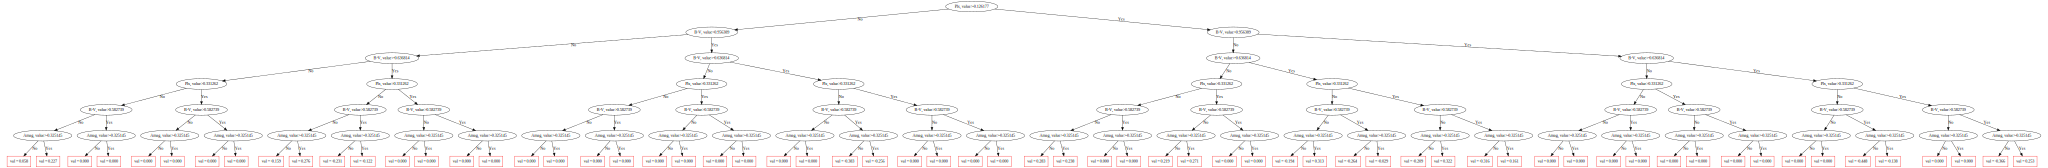

In [142]:
from IPython.display import display
from catboost import Pool

train_pool = Pool(
    data = X_train_filt,
    label = y_train,
    cat_features = ['SpType'] if 'SpType' in X_train_filt.columns else []
)

graph = cat_raw.plot_tree(tree_idx=0, pool=train_pool)

display(graph)

## 5. Регрессия:


   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.


In [143]:
y_reg = df['Amag'].reset_index(drop=True)
X_reg = pd.concat([
    df[reg_numeric].reset_index(drop=True),
    pd.DataFrame(
        encoder.transform(df[cat_features].reset_index(drop=True)),
        columns=encoder.get_feature_names_out(cat_features))
    ], axis=1)

In [144]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [145]:
xgb_reg = XGBRegressor(random_state=42)
param_reg = {
    'n_estimators': [100,200],
    'learning_rate': [0.01,0.1],
    'max_depth': [3,5],
    'reg_alpha': [0,0.1],
    'reg_lambda': [1,10]
}
grid_reg = GridSearchCV(xgb_reg, param_reg, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_reg.fit(X_train_r, y_train_r)
best_reg = grid_reg.best_estimator_
print("Regression best params:", grid_reg.best_params_)

Regression best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1}


   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.


In [146]:
y_pred_reg = best_reg.predict(X_test_r)
print("Before filtering:")
print("MSE:", mean_squared_error(y_test_r, y_pred_reg))
print("MAE:", mean_absolute_error(y_test_r, y_pred_reg))
print("R2:", r2_score(y_test_r, y_pred_reg))

Before filtering:
MSE: 0.018513186026842196
MAE: 0.06257775141968426
R2: 0.9820510016147834


   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.


In [147]:
missing_in_train = [f for f in top_features if f not in X_train_r.columns]
missing_in_test = [f for f in top_features if f not in X_test_r.columns]

if missing_in_train or missing_in_test:
    print(f"Удаляем отсутствующие признаки: {missing_in_train + missing_in_test}")
    top_features = [f for f in top_features if f not in missing_in_train + missing_in_test]

Удаляем отсутствующие признаки: ['SpType', 'Amag', 'SpType', 'Amag']


In [148]:
X_train_r_f = X_train_r[top_features]
X_test_r_f = X_test_r[top_features]

In [149]:
best_reg.fit(X_train_r_f, y_train_r)
y_pred_reg_f = best_reg.predict(X_test_r_f)
print("After filtering:")
print("MSE:", mean_squared_error(y_test_r, y_pred_reg_f))
print("MAE:", mean_absolute_error(y_test_r, y_pred_reg_f))
print("R2:", r2_score(y_test_r, y_pred_reg_f))

After filtering:
MSE: 0.022009906899878137
MAE: 0.05885831879661361
R2: 0.9786608429887815


   - Сравнить метрики до и после фильтрации.

После фильтрации метрики совсем немного ухудшидись
